## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import time

import torch
from torch import nn, optim
import torchvision
from torchvision import transforms, datasets, models, utils
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.nn import functional as F
from torch.optim import lr_scheduler

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
PATH_TO_DATA = 'D:/datasets/Adience/aligned'

## Loading data using Dataset and DataLoader

In [4]:
class AdienceData(Dataset):
    
    def __init__(self, csv_file_age, csv_file_gender, root_dir, transform):
        self.csv_file_age = csv_file_age
        self.csv_file_gender = csv_file_gender
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_data()
        
    def __len__(self):
        return len(self.data)
    
    def read_data(self):
        data = []
        f = open(self.)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, 
                                self.csv_file.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label_age = self.csv_file.iloc[idx, 1]
        label_gender = self.csv_file.iloc[idx, 2]
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label_age': label_age,
            'label_gender': label_gender
        }

In [5]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]


train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [6]:
batch_size = 20

train_dataset = AdienceData(csv_file='train.csv',
                              root_dir = PATH_TO_DATA,
                              transform = train_transforms)

valid_dataset = AdienceData(csv_file='valid.csv',
                              root_dir = PATH_TO_DATA,
                              transform = test_transforms)

test_dataset = AdienceData(csv_file='test.csv',
                              root_dir = PATH_TO_DATA,
                              transform = test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(valid_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 13352
Number of validation examples: 1483
Number of testing examples: 3709


In [8]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

<ipython-input-9-eb563a6458aa>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats 

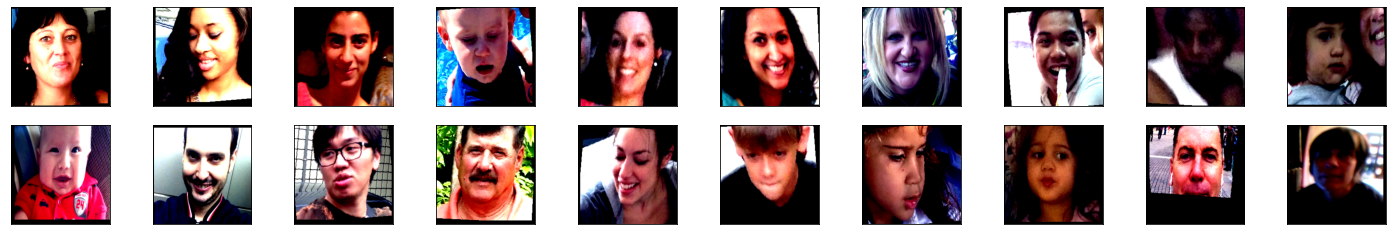

In [9]:
# obtain one batch of training images
dataiter = iter(train_loader)
batch = dataiter.next()
images, label1, label2 = batch['image'], batch['label_age'], batch['label_gender']
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
#     ax.set_title(classes[labels[idx]])

## Creating a Multioutput CNN model

In [10]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1e-2)

In [11]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_layer = nn.Sequential(
            
            # Conv Layer block 1
            nn.Conv2d(3, 64, 1, stride = 1),
            nn.SELU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 7, stride = 1),
            nn.SELU(inplace=True),
            nn.MaxPool2d(3, 3),
            nn.BatchNorm2d(64),
            
            # Conv Layer block 2
            nn.Conv2d(64, 128, 1, stride = 1),
            nn.SELU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 5, stride = 1),
            nn.SELU(inplace=True),
            nn.MaxPool2d(3, 3),
            nn.BatchNorm2d(128),
            
            # Conv Layer block 3
            nn.Conv2d(128, 256, 1, stride = 1),
            nn.SELU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride = 2),
            nn.SELU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 384, 1, stride = 1),
            nn.SELU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(384),
#             nn.AdaptiveMaxPool2d((7, 7)),     
        )
        
        
        self.fc_layer1 = nn.Sequential(
            nn.Linear(384*5*5, 1024),
            nn.SELU(inplace=True),
            nn.AlphaDropout(0.5),
            nn.Linear(1024, 512),
            nn.SELU(inplace=True),
            nn.AlphaDropout(0.5),            
            nn.Linear(512, 8)
        )
        
        self.fc_layer2 = nn.Sequential(
            nn.Linear(384*5*5, 1024),
            nn.SELU(inplace=True),
            nn.AlphaDropout(0.5),
            nn.Linear(1024, 512),
            nn.SELU(inplace=True),
            nn.AlphaDropout(0.5),            
            nn.Linear(512, 2)
        )
        
        
        self.apply(weights_init)
        
    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        label1 = self.fc_layer1(x)
        label2 = self.fc_layer2(x)
#         label2 = torch.sigmoid(self.fc_layer2(x))
        
        return {'label1': label1, 'label2': label2}

In [12]:
# import pretrainedmodels
# class Net(nn.Module):
#     def __init__(self, pretrained):
#         super(Net, self).__init__()
#         if pretrained is True:
#             self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
#         else:
#             self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
#         self.fc1 = nn.Linear(512, 8)  #For age class
#         self.fc2 = nn.Linear(512, 2)    #For gender class
# #         self.fc3 = nn.Linear(512, 4)    #For race class
        
#     def forward(self, x):
#         bs, _, _, _ = x.shape
#         x = self.model.features(x)
#         x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
#         label1 = self.fc1(x)
#         label2= torch.sigmoid(self.fc2(x))  
# #         label3= self.fc3(x)
#         return {'label1': label1, 'label2': label2}

In [13]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net().to(device)

# model = model.to(device)

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             256
              SELU-2         [-1, 64, 224, 224]               0
       BatchNorm2d-3         [-1, 64, 224, 224]             128
            Conv2d-4         [-1, 64, 218, 218]         200,768
              SELU-5         [-1, 64, 218, 218]               0
         MaxPool2d-6           [-1, 64, 72, 72]               0
       BatchNorm2d-7           [-1, 64, 72, 72]             128
            Conv2d-8          [-1, 128, 72, 72]           8,320
              SELU-9          [-1, 128, 72, 72]               0
      BatchNorm2d-10          [-1, 128, 72, 72]             256
           Conv2d-11          [-1, 128, 68, 68]         409,728
             SELU-12          [-1, 128, 68, 68]               0
        MaxPool2d-13          [-1, 128, 22, 22]               0
      BatchNorm2d-14          [-1, 128,

## Setting hyper-parameters

In [14]:
# for multilabel output: age
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000], gamma=0.1)

## Creating training model function

In [15]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
# def train_model(model, criterion1, criterion2, optimizer, scheduler, n_epochs=50):
#     """return trained model"""
#     # initialize tracker for minimum validation loss
#     valid_loss_min = np.Inf
#     print('Training started')
#     for epoch in range(1, n_epochs):
#         start_time = time.monotonic()
#         train_loss = 0.0
#         valid_loss = 0.0
#         # train the model
#         model.train()
#         for idx, batch in enumerate(train_loader):
#             # get data and move to GPU
#             image, label1, label2 = batch['image'].to('cuda'), batch['label_age'].to('cuda'), batch['label_gender'].to('cuda')
#             # zero the parameter gradients
#             optimizer.zero_grad()
#             output = model(image)
#             label1_hat = output['label1']
#             label2_hat = output['label2']
#             # calculate loss
#             loss1 = criterion1(label1_hat, label1.squeeze().long())
#             loss2 = criterion1(label2_hat, label2.squeeze().long())
#             loss = loss1 + loss2
#             # backprop
#             loss.backward()
#             # grad
#             optimizer.step()
#             scheduler.step()
#             train_loss = train_loss + ((1 / (idx + 1)) * (loss.data - train_loss))
#             if idx % 50 == 0:
#                 print('Epoch %d, Batch %d loss: %.6f' % (epoch, idx + 1, train_loss))
                
#         # validate the model 
#         model.eval()
#         for idx, batch in enumerate(valid_loader):
#             # get data and move to GPU
#             image, label1, label2 = batch['image'].to('cuda'), batch['label_age'].to('cuda'), batch['label_gender'].to('cuda')
#             output = model(image)
#             label1_hat = output['label1']
#             label2_hat = output['label2']
#             # calculate loss
#             loss1 = criterion1(label1_hat, label1.squeeze().long())
#             loss2 = criterion1(label2_hat, label2.squeeze().long())
#             loss = loss1 + loss2
#             valid_loss = valid_loss + ((1 / (idx + 1)) * (loss.data - valid_loss))
            
#             end_time = time.monotonic()
#             epoch_mins, epoch_secs = epoch_time(start_time, end_time)
#             print('#################################################')
#             print(f'Epoch: {epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#             # print training/validation statistics
#             for param_group in optimizer.param_groups:
#                 print("Current learning rate is: {}".format(param_group['lr'])) 
#             print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
            
#             # save the model if validation loss has decreased
#             if valid_loss < valid_loss_min:
#                 torch.save(model, 'model.pt')
#                 print('Validation loss decreased ({:.6f}) --> {:.6f}. Saving model ...'.format(valid_loss_min, valid_loss))
#                 valid_loss_min = valid_loss
#         # return trained model
# #         return model

Training started
Epoch: 1 | Epoch Time: 5m 53s
Current learning rate is: 0.0001
Training Loss: 2.176828 	Validation Loss: 3.676485
Validation loss decreased (inf --> 3.676485)
Epoch: 2 | Epoch Time: 5m 55s
Current learning rate is: 0.0001
Training Loss: 1.756073 	Validation Loss: 2.719383
Validation loss decreased (3.676485 --> 2.719383)
Epoch: 3 | Epoch Time: 5m 45s
Current learning rate is: 0.0001
Training Loss: 1.580435 	Validation Loss: 2.705026
Validation loss decreased (2.719383 --> 2.705026)
Epoch: 4 | Epoch Time: 5m 44s
Current learning rate is: 0.0001
Training Loss: 1.468860 	Validation Loss: 2.925262
Epoch: 5 | Epoch Time: 5m 49s
Current learning rate is: 0.0001
Training Loss: 1.385105 	Validation Loss: 2.236590
Validation loss decreased (2.705026 --> 2.236590)
Epoch: 6 | Epoch Time: 5m 50s
Current learning rate is: 0.0001
Training Loss: 1.312741 	Validation Loss: 2.389315
Epoch: 7 | Epoch Time: 5m 50s
Current learning rate is: 0.0001
Training Loss: 1.239933 	Validation Loss:

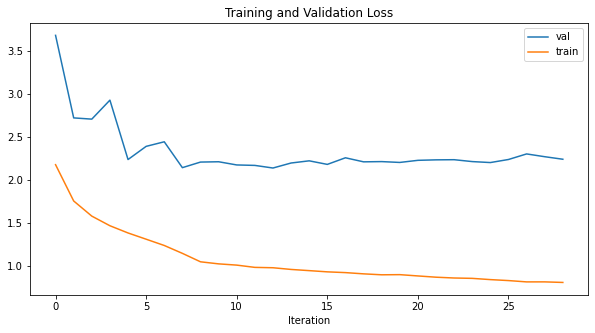

In [17]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss
train_loss_list = []
valid_loss_list = []

print('Training started')
for epoch in range(1, n_epochs):
    start_time = time.monotonic()
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for i, batch in enumerate(train_loader):
        # get data and move to GPU
        image, label1, label2 = batch['image'].to('cuda'), batch['label_age'].to('cuda'), batch['label_gender'].to('cuda')
        # zero the parameter gradients
        optimizer.zero_grad()
        output = model(image)
        label1_hat = output['label1']
        label2_hat = output['label2']
        # calculate loss
        loss1 = criterion(label1_hat, label1.squeeze().long())
        loss2 = criterion(label2_hat, label2.squeeze().long())
        loss = loss1 + loss2
        # backprop
        loss.backward()
        # grad
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()*image.size(0)
        
    ######################
    # validate the model #
    ######################
    model.eval()
    for i, batch in enumerate(valid_loader):
        # get data and move to GPU
        image, label1, label2 = batch['image'].to('cuda'), batch['label_age'].to('cuda'), batch['label_gender'].to('cuda')
        output = model(image)
        label1_hat = output['label1']
        label2_hat = output['label2']
        # calculate loss
        loss1 = criterion(label1_hat, label1.squeeze().long())
        loss2 = criterion(label2_hat, label2.squeeze().long())
        loss = loss1 + loss2
        valid_loss += loss.item()*image.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    train_loss_list.append(train_loss)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_loss_list.append(valid_loss)
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    # print training/validation statistics 
    for param_group in optimizer.param_groups:
                print("Current learning rate is: {}".format(param_group['lr']))    
    print(f'Training Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f})')
        torch.save(model.state_dict(), 'model1.pt')
        valid_loss_min = valid_loss
        

plt.figure(figsize=(10,5))
plt.title('Training and Validation Loss')
plt.plot(valid_loss_list, label='val')
plt.plot(train_loss_list, label='train')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [18]:
# model

In [19]:
# model_train = train_model(model, criterion_multi, criterion_binary, optimizer, scheduler, n_epochs=50)

In [20]:
model.load_state_dict(torch.load('model1.pt'))

<All keys matched successfully>

In [26]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for batch in loader:
            x = batch['image'].to(device)
            y = batch['label_age'].to(device)
            
            scores = model(x)
            _, predictions = scores['label1'].max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
        
    model.train()
    
check_accuracy(test_loader, model)

Got 2471 / 3709 with accuracy 66.62


In [27]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for batch in loader:
            x = batch['image'].to(device)
            y = batch['label_gender'].to(device)
            
            scores = model(x)
            _, predictions = scores['label2'].max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
        
    model.train()
    
check_accuracy(test_loader, model)

Got 3473 / 3709 with accuracy 93.64


In [28]:
def test(model, dataloader):
    result = {
        'exact_match': 0,
        'total': 0,
        'one_off_match': 0
        
    }
    
    with torch.no_grad():
        model.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label_age'].to(device)
            outputs = model(images)
            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs['label1']))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            result['one_off_match'] += (sum(outputs==labels)+
                                        sum(outputs==labels-1)+
                                        sum(outputs==labels+1)).item()
            
    return result

In [29]:
accuracy = test(model, test_loader)

In [30]:
print(f"Age Accuracy: {accuracy['exact_match']*100/accuracy['total']}, \tOne-off Accuracy: {accuracy['one_off_match']*100/accuracy['total']}")

Age Accuracy: 66.62173092477757, 	One-off Accuracy: 91.18360744135886


## Confusion Matrix

In [31]:
ROOT_DIR = '.'
IMAGES_PATH = os.path.join(ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [43]:
from sklearn.metrics import confusion_matrix

# Initialize the prediction and label lists(tensors)
predlist_age=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist_age=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        with torch.no_grad():
            image, target = batch['image'].to(device), batch['label_age'].to(device)
            outputs = model(image)
            _, preds = torch.max(outputs['label1'], 1)
            
            predlist_age = torch.cat([predlist_age, preds.view(-1).cpu()])
            lbllist_age = torch.cat([lbllist_age, target.view(-1).cpu()])
        
# confusion matrix
conf_mat = confusion_matrix(lbllist_age.numpy(), predlist_age.numpy())
print('For Age: \n', conf_mat)

For Age: 
 [[457  18   3   1   1   3   0   1]
 [ 82 291  25   6   3   1   0   0]
 [  9  53 325  25  30   4   0   0]
 [  1   2  38 169 109  20   0   6]
 [  4   9  35  75 762 170   7  10]
 [  3   8  10  18 176 285  14  39]
 [  1   2   3   3  22  70  45  44]
 [  0   0   8   1  13  40  12 137]]


In [44]:
# Accuracy for each class label
print('Age accuracy for each class label')
class_accuracy = 100 * conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

Age accuracy for each class label
[94.4214876  71.32352941 72.86995516 48.98550725 71.08208955 51.53707052
 23.68421053 64.92890995]


In [45]:
from sklearn.metrics import confusion_matrix

# Initialize the prediction and label lists(tensors)
predlist_gender=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist_gender=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        with torch.no_grad():
            image, target = batch['image'].to(device), batch['label_gender'].to(device)
            outputs = model(image)
            _, preds = torch.max(outputs['label2'], 1)
            
            predlist_gender = torch.cat([predlist_gender, preds.view(-1).cpu()])
            lbllist_gender = torch.cat([lbllist_gender, target.view(-1).cpu()])
        
# confusion matrix
conf_mat = confusion_matrix(lbllist_gender.numpy(), predlist_gender.numpy())
print('For Gender: \n', conf_mat)

For Gender: 
 [[1765  132]
 [ 104 1708]]


In [46]:
# Accuracy for each class label
print('Gender accuracy for each class label')
class_accuracy = 100 * conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

Gender accuracy for each class label
[93.0416447  94.26048565]


Saving figure Age Confusion Matrix


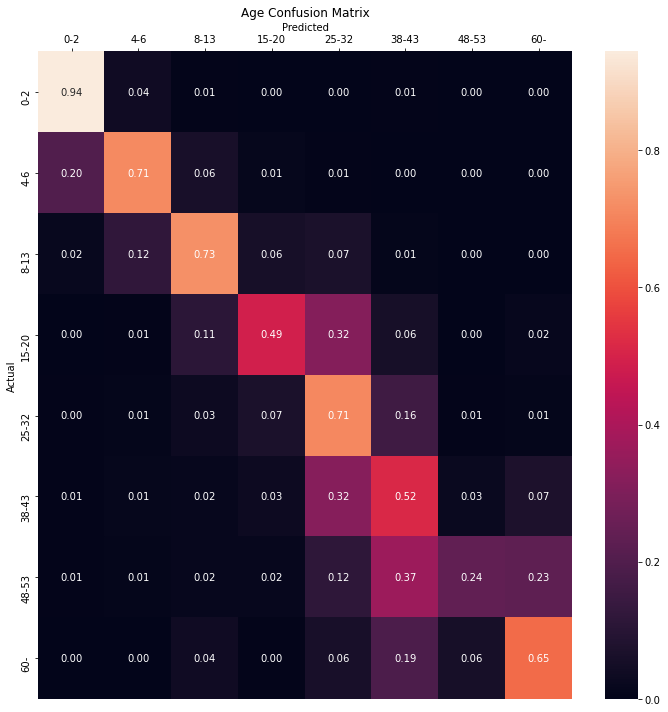

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

target_names = ['0-2', '4-6', '8-13', '15-20', '25-32', '38-43', '48-53', '60-']

cm = confusion_matrix(lbllist_age.numpy(), predlist_age.numpy(),)
# Normalise=
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.title('Age Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
save_fig('Age Confusion Matrix')
plt.show(block=False)

Saving figure Gender Confusion Matrix


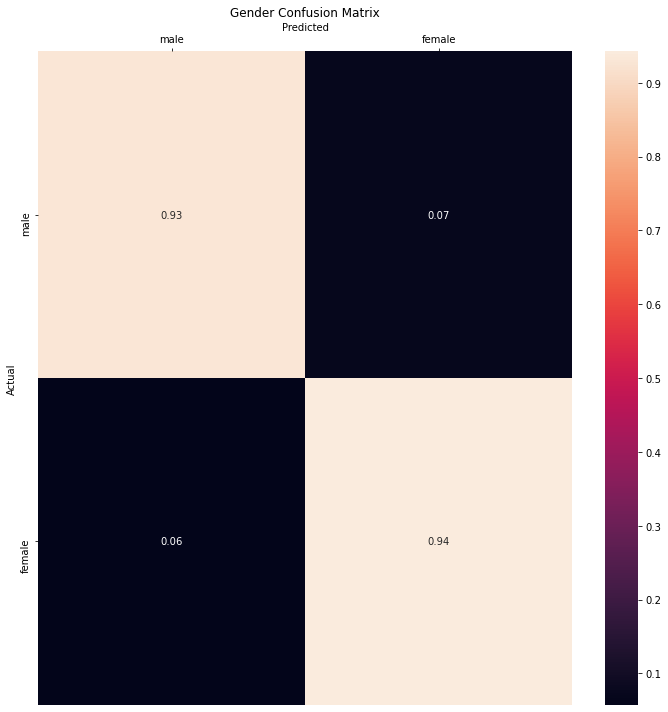

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

target_names = ['male', 'female']

cm = confusion_matrix(lbllist_gender.numpy(), predlist_gender.numpy(),)
# Normalise=
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.title('Gender Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
save_fig('Gender Confusion Matrix')
plt.show(block=False)

## AGE
#### We can then get all of the correct predictions, filter them out, and then sort all of the incorrect predictions based on how confident they were on their incorrect prediction.

In [49]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for batch in iterator:
    
            x = batch['image'].to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred['label1'], dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(batch['label_age'].cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [50]:
images, labels, probs = get_predictions(model, test_loader)

#... which we then use to get the predicted labels.

pred_labels = torch.argmax(probs, 1)

In [51]:
corrects = torch.eq(labels, pred_labels)

In [52]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [53]:
classes = ['0-2', '4-6', '8-13', '15-20', '25-32', '38-43', '48-53', '60-']

We can then plot the most incorrectly predicted images along with the predicted class and the actual class.

In [54]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

In [56]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

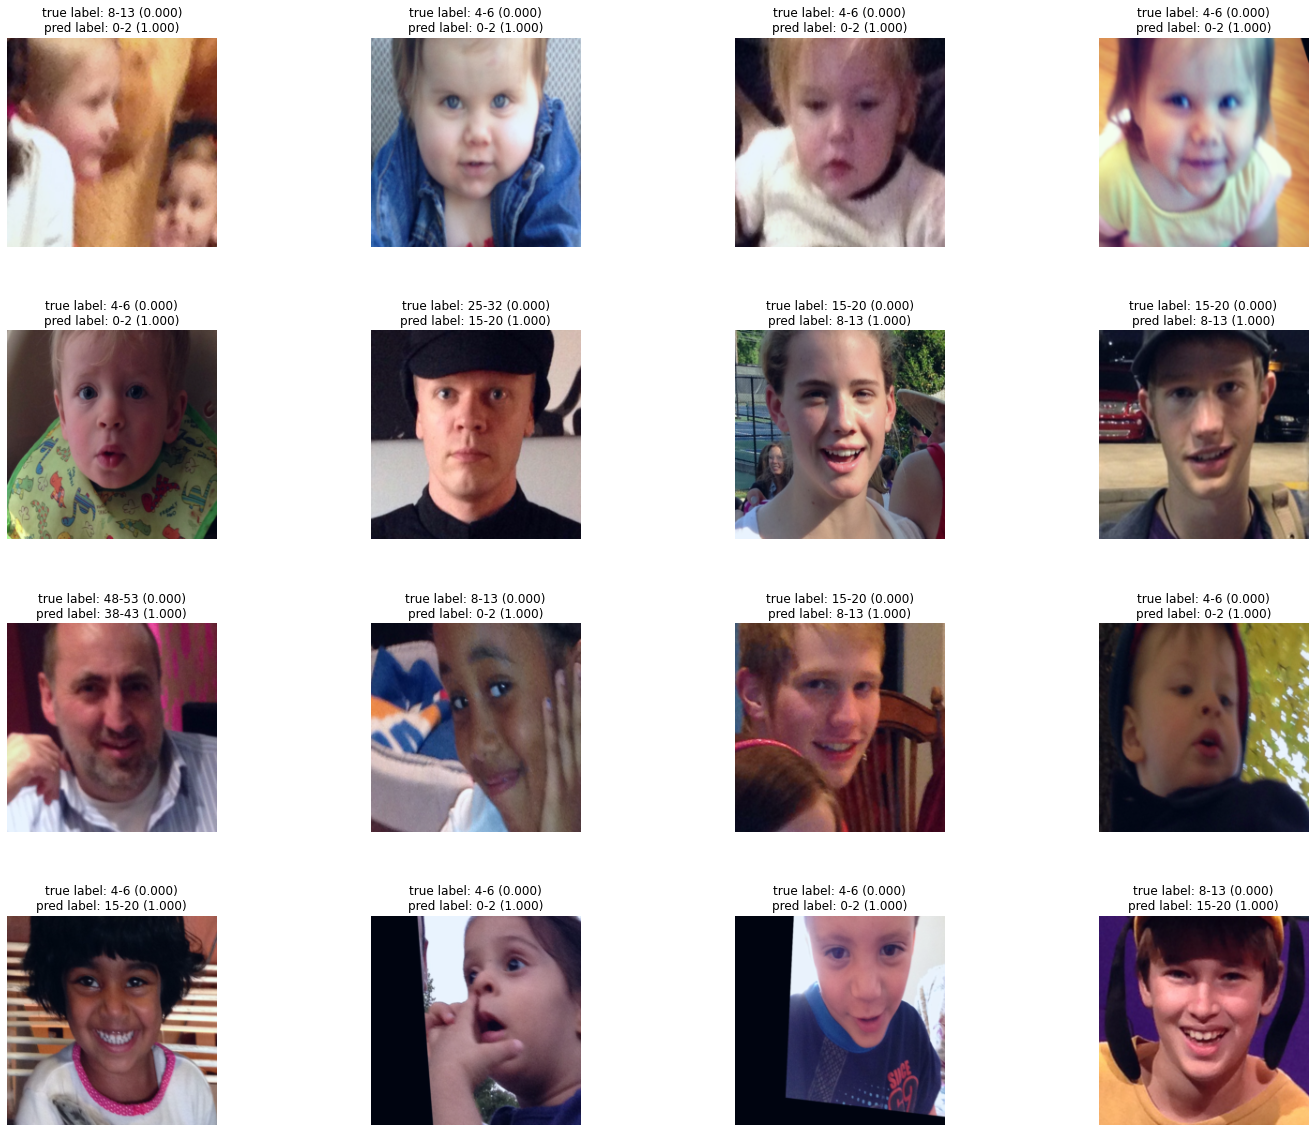

In [57]:
N_IMAGES = 20

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

## Gender

#### We can then get all of the correct predictions, filter them out, and then sort all of the incorrect predictions based on how confident they were on their incorrect prediction.

In [58]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for batch in iterator:
    
            x = batch['image'].to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred['label2'], dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(batch['label_gender'].cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [59]:
images, labels, probs = get_predictions(model, test_loader)

#... which we then use to get the predicted labels.

pred_labels = torch.argmax(probs, 1)

In [60]:
corrects = torch.eq(labels, pred_labels)

In [61]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [62]:
classes = ['male', 'female']

In [63]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

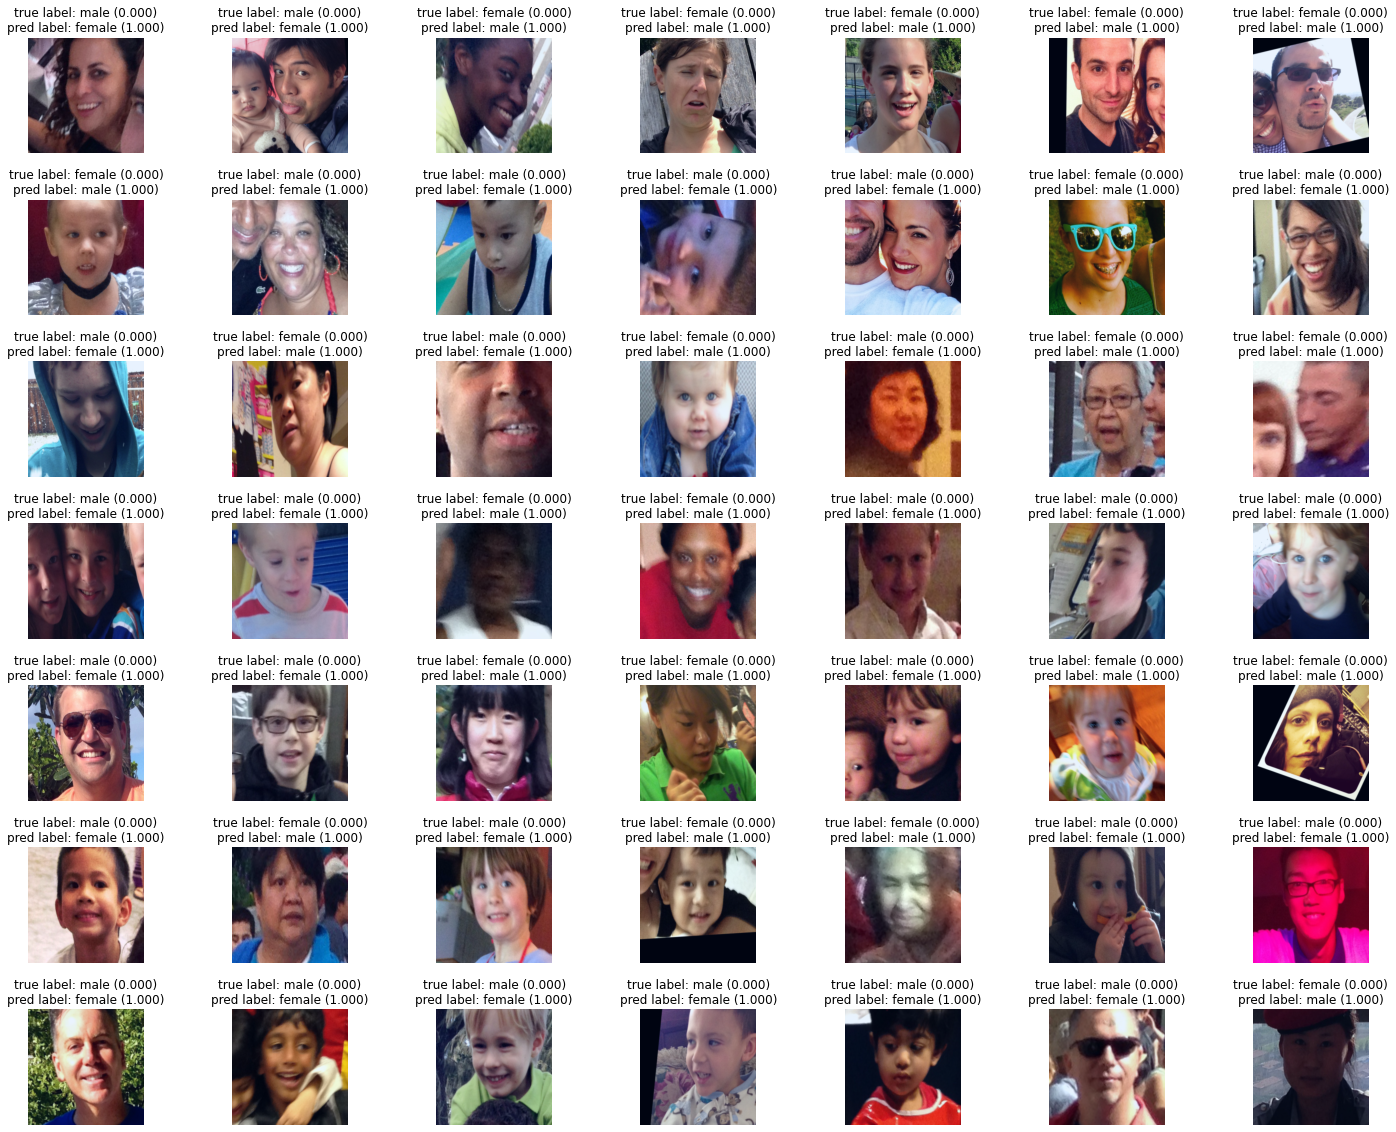

In [65]:
N_IMAGES = 50

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)